# Reinforcement Learning in Competitive Blackjack
#### CS 4501 Project 3
Param Damle, Sid Burre, Kelvin Peng

## Imports / Global Functions

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
# sns.set_theme()


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

In [2]:
def bust(hand):
  return np.sum(hand) > 21

def possible_values(hand):
  possible_values = [np.sum(hand)]
  for i in range(hand.count(1)):
    possible_values.append(possible_values[0] + ((i+1)*10))  # account for Ace dual value
  return tuple(possible_values)

## Load / Clear Data

In [ ]:
# reset probability pickles
possible_settings = [(False, 0),] + [(True, x) for x in range(3)]

for i in possible_settings: 
  if input("Are you sure you want to flush data for bot " + str(i[0]) + " " + str(i[1]) + "?") == 'y':
    bot_state_specific = i[0]
    bot_strategy = i[1]
    filename = "bj_belief_" + str(bot_strategy) + ("s" * bot_state_specific)    
    if bot_state_specific:
      temp_belief = np.ones((26,2)) / 2
    else:
      temp_belief = np.ones(2) / 2
    tempfile = open(filename, 'wb')
    pickle.dump((1,temp_belief), tempfile)
    tempfile.close()
    
    temp_beliefs = []
    filenameCum = "beliefs_per_iter" + str(bot_strategy) + ("s" * bot_state_specific)
    if bot_state_specific:
      temp_belief = np.ones((26,2)) / 2
    else:
      temp_belief = np.ones(2) / 2
    temp_beliefs.append(temp_belief)
    
    tempfile = open(filenameCum, 'wb')
    pickle.dump(temp_beliefs, tempfile)
    tempfile.close()
    print("FLUSHED DATA for bot " + str(i[0]) + " " + str(i[1]))
  else:
    print("no data flushed for bot " + str(i[0]) + " " + str(i[1]))

Are you sure you want to flush data for bot False 0?y
FLUSHED DATA for bot False 0
Are you sure you want to flush data for bot True 0?y
FLUSHED DATA for bot True 0
Are you sure you want to flush data for bot True 1?y
FLUSHED DATA for bot True 1
Are you sure you want to flush data for bot True 2?y
FLUSHED DATA for bot True 2


In [3]:
### View any stored belief
bot_state_specific = True
bot_strategy = 0
filename = "bj_belief_" + str(bot_strategy) + ("s" * bot_state_specific)    
tempfile = open(filename, 'rb')
(generation, prior_belief) = pickle.load(tempfile)  
# generation = how many rounds bot has been trained
# prior_belief = trained beliefs for picking any given action
tempfile.close()
(generation, prior_belief)

(3696, array([[5.66177603e-02, 9.43382240e-01],
        [1.01857986e-03, 9.98981420e-01],
        [1.77897817e-03, 9.98221022e-01],
        [2.44687732e-04, 9.99755312e-01],
        [4.89982561e-07, 9.99999510e-01],
        [1.58093046e-06, 9.99998419e-01],
        [1.22158507e-15, 1.00000000e+00],
        [1.54421700e-22, 1.00000000e+00],
        [2.33332123e-24, 1.00000000e+00],
        [1.13717250e-19, 1.00000000e+00],
        [1.69393717e-17, 1.00000000e+00],
        [3.05277792e-16, 1.00000000e+00],
        [7.31412875e-10, 9.99999999e-01],
        [5.19095646e-10, 9.99999999e-01],
        [8.75222457e-07, 9.99999125e-01],
        [9.99979800e-01, 2.01996017e-05],
        [1.00000000e+00, 2.90296096e-51],
        [3.37756774e-02, 9.66224323e-01],
        [2.47338809e-04, 9.99752661e-01],
        [8.95068750e-04, 9.99104931e-01],
        [3.22298688e-04, 9.99677701e-01],
        [8.01561202e-04, 9.99198439e-01],
        [2.17244302e-05, 9.99978276e-01],
        [2.32443465e-03, 9.9

## Player Definitions

In [6]:
class HumanPlayer:
  def __init__(self, my_hand, opp_hands, num_decks=6):
    self.hand = [my_hand[0], my_hand[1]] # list of integers (repeats and appends allowed)
    self.opp_hands = opp_hands # list of tuples
    self.num_decks = num_decks # number of decks in circulation
    
    self.card_totals = {} # maps a card number to amount of cards in circulation (in deck or face down)
    for number_card in range(1,10): # 1 = A
      self.card_totals[number_card] = 4*num_decks
    self.card_totals[10] = 16*num_decks  # 10, J, Q, K
    for card in self.hand:
      self.card_totals[card] -= 1
    for opp_hand in self.opp_hands:
      for card in opp_hand:
        self.card_totals[card] -= 1
    print("[Human] Your starting hand: " + str(self.hand))


  def deal(self, card):
    self.hand.append(card)
    self.card_totals[card] -= 1
    print("[Human] You've been dealt a card: " + str(card))
    print("[Human] Your current hand: " + str(self.hand))

  def hit(self):
    print("[Human] Type 'h' to hit, otherwise stand: ", end="")
    response = input()
    if (response == 'h') or (response == 'H'):
      return True  # player decides to hit
    return False # player decides to stand

  def win(self, reward):
    ################ REWARD
    print("[Human] You won " + str(reward) + " units!")

  def lose(self, punishment):
    ################ PUNISH
    print("[Human] You netted " + str(punishment) + " units.")

In [7]:
class AutoPlayer:
  def __init__(self, my_hand, opp_hands, num_decks=6, state_specific=True, name="Robot", iteration=1, prior_belief=None, strategy=0, verbose=True):
    self.hand = [my_hand[0], my_hand[1]] # list of integers (repeats and appends allowed)
    self.opp_hands = opp_hands # list of tuples
    self.num_decks = num_decks # number of decks in circulation
    self.state_specific = state_specific
    self.name = name
    self.last_move = (-1, 0)  # represents state, 0 for stand and 1 for hit
    self.t = iteration # with t^th robot are we training?
    # sqrt (num actions * 2 * log(num_actions) / t)
    self.gamma = min(1, math.sqrt(2 * 2 * math.log(2) / (self.t) ) )
    if self.state_specific:
      self.strategy = strategy
    else:
      self.strategy = 0

    self.card_totals = {} # maps a card number to amount of cards in circulation (in deck or face down)
    for number_card in range(1,10): # 1 = A
      self.card_totals[number_card] = 4*num_decks
    self.card_totals[10] = 16*num_decks  # 10, J, Q, K
    for card in self.hand:
      self.card_totals[card] -= 1
    for opp_hand in self.opp_hands:
      for card in opp_hand:
        self.card_totals[card] -= 1
    if verbose : print("[" + self.name + "] Starting hand: " + str(self.hand))

    ############# PICKLE LOAD
    if prior_belief is not None:
      self.belief = prior_belief
    else:
      if self.state_specific:
        self.belief = np.ones((26,2)) / 2
      else:
        self.belief = np.ones(2) / 2
    self.prior_belief = np.copy(self.belief)

    if np.isnan(self.belief).any():
      print("belief had nan from the get go")

    '''
    Type I: bold (epsilon greedy) (naive) (strategy 0)
    action_prob = (1-epsilon)*belief + (epsilon * 1/2)

    Type II: cautious (game programmed) (strategy 1)  [ONLY STATE SPECIFIC]
    action_prob = (1-p_bust)*belief + p_bust*stand

    Type III: mix (strategy 2)   [ONLY STATE SPECIFIC]
    action_prob = (1-epsilon)*((1-p_bust)*belief + p_bust*stand) + (epsilon * 1/2)
    '''
      
    # action probability 0 = stand, 1 = hit
    if (self.strategy == 0):
      self.action_probability = (1.0 - self.gamma) * self.belief + self.gamma / 2
    elif self.strategy == 1:

      self.action_probability = ((1.0-self.p_bust()) * self.belief) + np.asarray([[self.p_bust(), 0] for i in range(26)])
    else: # strategy = 2
      self.action_probability = ((1.0 - self.gamma)*(((1.0-self.p_bust()) * self.belief) + np.asarray([[self.p_bust(), 0] for i in range(26)]))) + self.gamma / 2

    if np.isnan(self.action_probability).any():
      print("pre divide " + str(self.action_probability))

    # normalize probabilities to sum to 1
    oldprob = self.action_probability
    if self.state_specific:
      bruh = np.sum(self.action_probability, axis=1)[:,None]
      self.action_probability /= np.sum(self.action_probability, axis=1)[:,None]
    else:
      bruh = np.sum(self.action_probability)
      self.action_probability /= np.sum(self.action_probability)
      
    if np.isnan(self.action_probability).any():
      print("what we believed: " + str(self.belief))
      print("p bust: " + str(self.p_bust()))
      print("old: " + str(oldprob))
      print("divisor: " + str(bruh))
      print("post divide " + str(self.action_probability))

  def p_bust(self):
    # returns the probability that hitting will put agent over 21 in any case
    total_cards_in_deck = 0
    for card_val in self.card_totals:
      total_cards_in_deck += self.card_totals[card_val]
    threshold = 21 - sum(self.hand) # if over threshold, we bust
    if threshold >= 10:
      return 0   # if we need more than 10 to bust, no card will force us to bust
    bust_cards_in_deck = 0
    for card_val in self.card_totals:
      if card_val > threshold:
        bust_cards_in_deck += self.card_totals[card_val]
    return bust_cards_in_deck/total_cards_in_deck


  def values(self):
    possible_values = [np.sum(self.hand)]
    for i in range(self.hand.count(1)):
      possible_values.append(possible_values[0] + ((i+1)*10))  # account for Ace dual value
    return tuple(possible_values)


  def deal(self, card):
    self.hand.append(card)
    self.card_totals[card] -= 1
    if verbose : print("[" + self.name + "] Dealt card: " + str(card))
    if verbose : print("[" + self.name + "] Current hand: " + str(self.hand))


  def hit(self):
    if 21 in self.values(): # already most optimal position
      if verbose : print("[" + self.name + "] Blackjack! I stand.")
      return False  # stand
    if min(self.values()) > 21:
      if verbose : print("[" + self.name + "] Bust! I must stand.")
      return False  # busted... punish?

    decision = False

    curr_state = -1
    
    if self.state_specific:
      if (1 in self.hand) and (np.sum(self.hand)-1 < 10):  # ace present in hand. if OTHER cards add up to more than 10, ace becomes default 1. if they add up to exactly 10, then you would've auto-stood at 21
        curr_state = np.sum(self.hand) + 15
      else:  # all cards in hand are non-aces
        curr_state = np.sum(self.hand) - 4
      # print(self.hand)
      # print(curr_state)
      decision = bool(np.random.choice(2, p=self.action_probability[curr_state,:]))
    else:
      decision = bool(np.random.choice(2, p=self.action_probability))

    self.last_move = (curr_state, int(decision))

    if decision == 1:
      if verbose : print("[" + self.name + "] I choose to hit!")
      return True  # player decides to hit
    else:
      if verbose : print("[" + self.name + "] I choose to stand.")
      return False # player decides to stand


  def win(self, reward):
    if verbose : print("[" + self.name + "] Yay! I won " + str(reward) + " units!")


  def lose(self, punishment):
    if verbose : print("[" + self.name + "] Aw, I netted " + str(punishment) + " units.")


  def change_belief(self, reward):
    if self.state_specific:
      estimatedReward = reward / self.action_probability[self.last_move[0],self.last_move[1]]
    else:
      estimatedReward = reward / self.action_probability[self.last_move[1]]
    return (self.last_move[0],self.last_move[1], math.exp(estimatedReward * self.gamma / 2) )

In [8]:
class HardCodedPlayer:
  def __init__(self, my_hand, opp_hands, num_decks=6, name="Robot", verbose=True):
    self.hand = [my_hand[0], my_hand[1]] # list of integers (repeats and appends allowed)
    self.opp_hands = opp_hands # list of tuples
    self.num_decks = num_decks # number of decks in circulation
    self.name = name
    if verbose : print("[" + self.name + "] Starting hand: " + str(self.hand))

  def values(self):
        possible_values = [np.sum(self.hand)]
        for i in range(self.hand.count(1)):
            possible_values.append(possible_values[0] + ((i+1)*10))  # account for Ace dual value
        return tuple(possible_values)

  def deal(self, card):
      self.hand.append(card)
      if verbose : print("[" + self.name + "] Dealt card: " + str(card))
      if verbose : print("[" + self.name + "] Current hand: " + str(self.hand))

  def hit(self):
      if 21 in self.values(): # already most optimal position
          if verbose : print("[" + self.name + "] Blackjack! I stand.")
          return False  # stand
      if min(self.values()) > 21:
          if verbose : print("[" + self.name + "] Bust! I must stand.")
          return False  # busted... punish?
      decision = False

      if (1 in self.hand):
        if (np.sum(self.hand)-1) <= 6:
          decision = True
        elif (np.sum(self.hand)-1) == 7:
          decision =  (self.opp_hands[-1][0] >= 9) or (1 in self.opp_hands[-1])
        else:
          decision =  False
      else:
        if np.sum(self.hand) <= 11:
          decision = True
        elif np.sum(self.hand) == 12:
          decision = (self.opp_hands[-1][0] <= 3) or (self.opp_hands[-1][0] >= 7)
        elif np.sum(self.hand) <= 16:
          decision = (1 in self.opp_hands[-1]) or (self.opp_hands[-1][0] >= 7)
        else:
          decision = False

      # if 1 in self.hand: # "soft hand" (has A)
      #     if max(self.values()) < 18:
      #         decision = True
      # else: # "hard hand" (no A)
      #     if self.opp_hands[-1][0] >= 7: # dealer's hand is good
      #         if max(self.values()) < 17:
      #             decision = True
      #     elif self.opp_hands[-1][0] <= 3: # dealer's hand is alright
      #         if max(self.values()) < 13:
      #             decision = True
      #     elif self.opp_hands[-1][0] <= 6: # dealer's hand is bad
      #         if max(self.values()) < 12:
      #             decision = True
      
      if decision:
          if verbose : print("[" + self.name + "] I choose to hit!")
          return True  # player decides to hit
      else:
          if verbose : print("[" + self.name + "] I choose to stand.")
          return False # player decides to stand

  def win(self, reward):
    if verbose : print("[" + self.name + "] Yay! I won " + str(reward) + " units!")


  def lose(self, punishment):
    if verbose : print("[" + self.name + "] Aw, I netted " + str(punishment) + " units.")

## Training

In [ ]:
dealer = True
human = False
num_decks = 1
num_players = 5  

bot_state_specific = True
bot_strategy = 3

possible_settings = [(False, 0),] + [(True, x) for x in range(3)]

verbose = False

num_epochs = 3695

for i in possible_settings: 
  bot_state_specific, bot_strategy = i
  print("starting " + str(bot_strategy) + ("s" * bot_state_specific) )
  for epoch in range(num_epochs):
    # if epoch % 100 == 0:
    #   print(epoch)

    filename = "bj_belief_" + str(bot_strategy) + ("s" * bot_state_specific) 
    filenameCum = "beliefs_per_iter" + str(bot_strategy) + ("s" * bot_state_specific)

    tempfile = open(filename, 'rb+')
    (generation, prior_belief) = pickle.load(tempfile)  
    # generation = how many rounds bot has been trained
    # prior_belief = trained beliefs for picking any given action
    tempfile.close()

    tempfile = open(filenameCum, 'rb+')
    prior_beliefs = pickle.load(tempfile)
    tempfile.close()


    # at least 2 if dealer is not present, otherwise 1
    if (not dealer):
      num_players = max(num_players, 2)
    else:
      num_players = max(num_players, 1)

    human_turn = np.random.choice(num_players)
    names = ["Bot " + str(i) for i in range(num_players)]
    if human:
      names[human_turn] = "Human"
    if dealer:
      names.append("Dealer")

    if verbose : print("Players: " + str(names))

    # create and shuffle deck
    deck = []
    for nd in range(num_decks):
      for i in range(1,10):
        for suit in range(4):
          deck.append(i)
      for face in range(16):
        deck.append(10)
    np.random.shuffle(deck)

    # deal initial cards
    all_hands = []  # length = num_players (+1 if dealer exists)
    for p in range(num_players):
      all_hands.append([deck.pop(), deck.pop()])

    if(dealer):
      next_card = deck.pop()
      all_hands.append([next_card, ])

    if verbose : print("Starting Hands: " + str(all_hands))

    players = []

    for p in range(num_players):  # players go one at a time, COULD CHANGE THIS LATER?
      if verbose : print()
      curr_hand = tuple(all_hands[p])
      curr_opp_hands = []
      for p2 in range(len(all_hands)):
        if p2 != p:
          curr_opp_hands.append(tuple(all_hands[p2]))
      
      if human and (p == human_turn):
        curr_player = HumanPlayer(curr_hand,curr_opp_hands,num_decks=num_decks)
      else:
        curr_player = AutoPlayer(curr_hand,curr_opp_hands,num_decks=num_decks, state_specific=bot_state_specific, name=names[p], strategy=bot_strategy, iteration=generation, verbose=verbose, prior_belief=prior_belief)
      players.append(curr_player)

      while(curr_player.hit()):
        # deal player a card
        curr_card = deck.pop()
        all_hands[p].append(curr_card)
        curr_player.deal(curr_card)
        if bust(all_hands[p]):
          if verbose : print("[" + names[p] + "] Bust!")
          break

    # dealer's behavior, no variability
    if dealer:
      if verbose : print()
      while max(possible_values(all_hands[-1])) < 17:
        curr_card = deck.pop()
        all_hands[-1].append(curr_card)
        if verbose : print("[Dealer] Draws card: " + str(curr_card))
        if verbose : print("[Dealer] Hand: " + str(all_hands[-1]))

    if verbose : print()
    # decide who won
    winners = []
    max_score = -1
    for p in range(len(all_hands)):
      for valuation in possible_values(all_hands[p]):
        if valuation > 21:  # don't want to award win to a valuation that busts
          continue
        if valuation > max_score:
          max_score = valuation
          winners = [p,]
        elif valuation == max_score:
          winners.append(p)
    # print(winners)

    if(len(winners) > 0):
      reward = (len(all_hands) * 1.0/len(winners))-1
    else:
      reward = -1  # everyone busted

    final_belief = prior_belief 

    generation += 1

    # print("Before: " + str(final_belief))
    for p in range(num_players):
      if p in winners:
        players[p].win(reward)  # maybe reward inversely proportional to number of winners?
        # each player and dealer adds 1 unit to pool, which is split amongst winners
        # subtract one for initial investment
        curr_reward = reward
      else:
        players[p].lose(-1)
        curr_reward = -1
      if (not human) or (human and (p != human_turn)):
        change = players[p].change_belief(curr_reward)
        # print(change)
        if bot_state_specific:
          final_belief[change[0],change[1]] *= change[2]
        else:
          final_belief[change[1]]*=change[2]

    oldbelief = final_belief
    
    if bot_state_specific:
      bruh = np.sum(final_belief, axis=1)[:,None]
      final_belief /= np.sum(final_belief, axis=1)[:,None]
    else:
      bruh = np.sum(final_belief)
      final_belief /= np.sum(final_belief)

    if np.isnan(final_belief).any():
      print("oldb: " + str(oldbelief))
      print("divisorb: " + str(bruh))
      print("post divide b" + str(final_belief))

    # print("After: " + str(final_belief))

    # Sid's modification here. All I'm going to do is pickle load a matrix, append the current belief (final_belief), and then do nothing else
    # this should generate a matrix with the beliefs at each point
    # I might just do the probability of hitting (because p(standing) = 1 - p(hitting) )

    prior_beliefs.append(final_belief)


    tempfile = open(filename, 'wb')
    pickle.dump((generation,final_belief), tempfile)
    tempfile.close()

    tempfile = open(filenameCum, 'wb')
    pickle.dump(prior_beliefs, tempfile)
    tempfile.close()

    if(num_players in winners):
      if verbose : print("[Dealer] House wins " + str(reward) + " units.")
    elif dealer:  # dealer in the game but not in winners
      if verbose : print("[Dealer] House netted -1 unit.")

### Visualize Results of Training

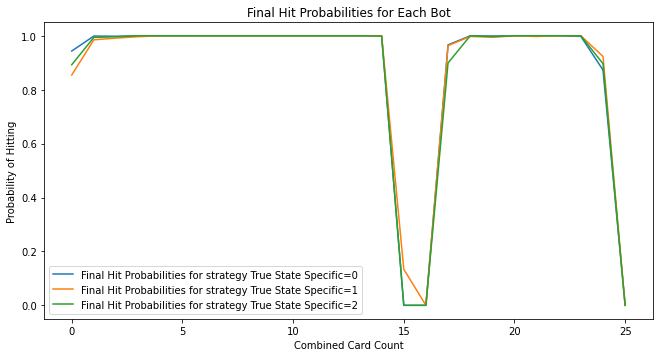

In [ ]:
# code to load and display a visualization of each of the bot's strategies: 
# I think we have 6 bots (bot states 1, 2, and 3) as well as T/F for state specific (there's one less than 6 but I'll operate as if there are 6)

graph_data = []
combined_data = []

bot_specifications = [(False, 0),] + [(True, x) for x in range(3)]

for i in bot_specifications:
    filenameCum = "bj_belief_" + str(i[1]) + ("s" * i[0])
    # load pickle file
    tempfile = open(filenameCum, 'rb')
    #prior_beliefs_false_1 = pickle.load(tempfile)  
    (generation, final_belief) = pickle.load(tempfile)
    combined_data.append(final_belief)
    # generation = how many rounds bot has been trained
    # prior_belief = trained beliefs for picking any given action
    tempfile.close()

# print(combined_data)

for i in range(1, len(combined_data)): 
    graph_data.append([0] * len(combined_data[i]))
    for j in range(0, len(combined_data[i])):
#         print(combined_data[i][j])
#         print("i: " + str(i))
#         print("j: " + str(j))
#         print(graph_data)
        
        graph_data[i - 1][j] = combined_data[i][j][1]


fig02 = plt.figure(figsize=(24,12))

ay = fig02.add_subplot(222)

for i in range(1, len(bot_specifications)): 
    ay.plot(range(0, 26), graph_data[i - 1], label="Final Hit Probabilities for strategy " + str(bot_specifications[i][0]) + " State Specific=" + str(bot_specifications[i][1]))
ay.legend(loc="lower left")

ay.set_xlabel('State')
ay.set_ylabel('Probability of Hitting')
ay.set_title('Final Hit Probabilities for Each Bot')

plt.show()


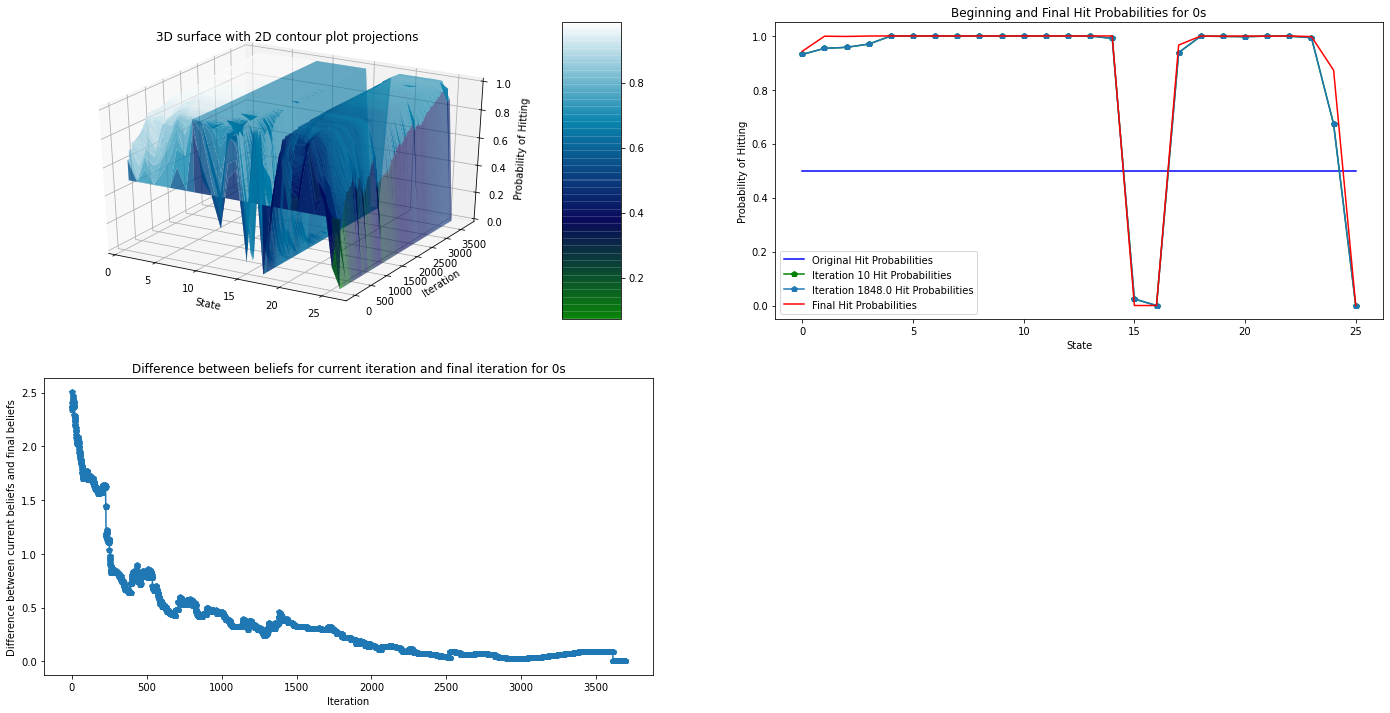

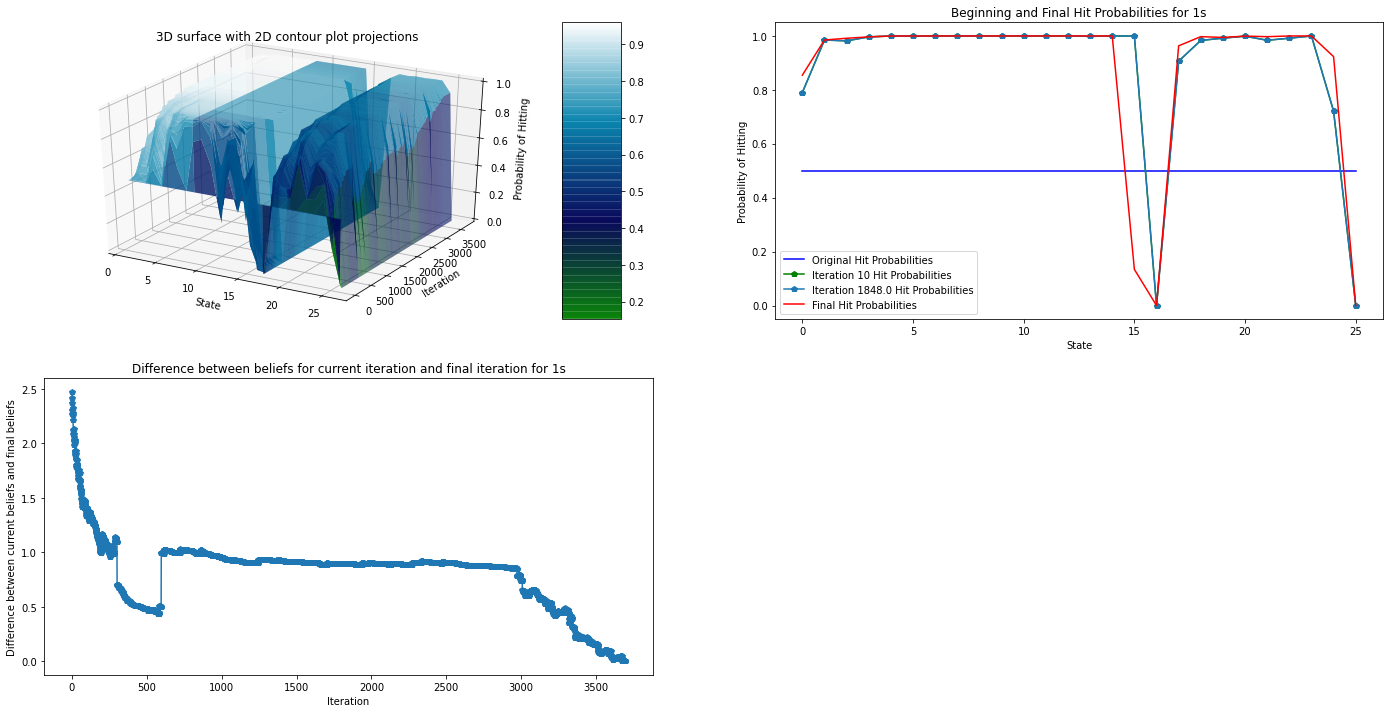

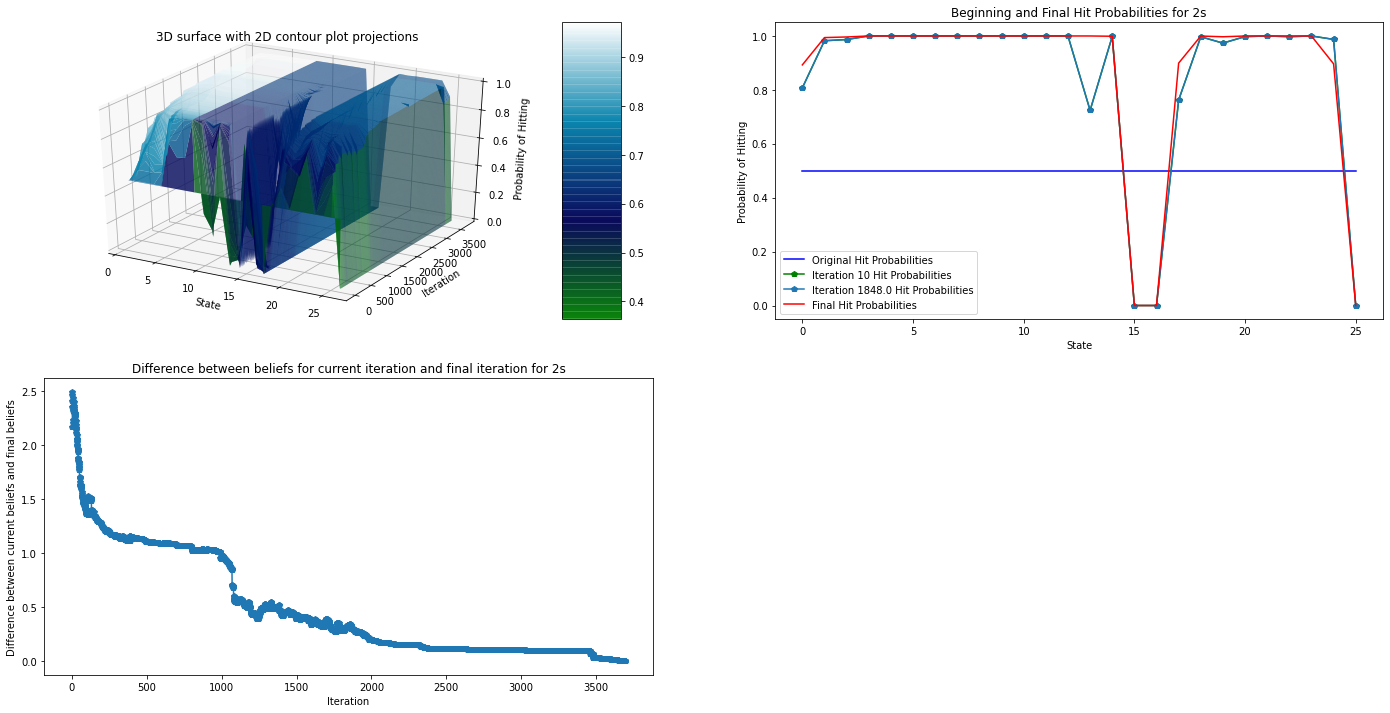

In [ ]:
possible_settings = [(True, x) for x in range(3)]

for possible_setting in possible_settings:
    bot_state_specific = possible_setting[0]
    bot_strategy = possible_setting[1]
    filenameCum = "beliefs_per_iter" + str(bot_strategy) + ("s" * bot_state_specific)
    # load pickle file
    tempfile = open(filenameCum, 'rb')
    prior_beliefs = pickle.load(tempfile)  
    # generation = how many rounds bot has been trained
    # prior_belief = trained beliefs for picking any given action
    tempfile.close()

#     print(prior_beliefs[0][1])

    list_of_beliefs = []

    for i in range(0, len(prior_beliefs)):
        list_of_beliefs.append([0] *  len(prior_beliefs[1]))
        for j in range(0, len(prior_beliefs[1])):  
            list_of_beliefs[i][j] = prior_beliefs[i][j][1]


    y=np.array([np.array(xi) for xi in list_of_beliefs])

    distanceArray = [0] * len(prior_beliefs)

    for i in range(0, len(y)): 
        distanceArray[i] = np.linalg.norm(y[i] - list_of_beliefs[len(list_of_beliefs) - 1])



    X = np.arange(0, len(list_of_beliefs))
    Y = np.arange(1, len(list_of_beliefs[0]) + 1)
    X, Y = np.meshgrid(Y, X)
    Z = y
    # Variable assignments above

    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(221, projection='3d')


    surf = ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.8, cmap=cm.ocean)
    #cset = ax.contourf(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.ocean)
    #cset = ax.contourf(X, Y, Z, zdir='x', offset=-5, cmap=cm.ocean)
    #cset = ax.contourf(X, Y, Z, zdir='y', offset=5, cmap=cm.ocean)


    fig.colorbar(surf, ax=ax, shrink=1, aspect=5)


    ax.set_xlabel('State')
    #ax.set_xlim(-5, 5)
    ax.set_ylabel('Iteration')
    #ax.set_ylim(-5, 5)
    ax.set_zlabel('Probability of Hitting')
    ax.set_zlim(np.min(Z), np.max(Z))
    ax.set_title('3D surface with 2D contour plot projections')

    ay = fig.add_subplot(222)
    ay.plot(range(0, 26), list_of_beliefs[0], '-b', label="Original Hit Probabilities")
    ay.plot(range(0, 26), list_of_beliefs[int(len(list_of_beliefs)/2)], '-gp', label="Iteration " + str(10) + " Hit Probabilities")
    ay.plot(range(0, 26), list_of_beliefs[int(len(list_of_beliefs)/2)], '-p', label="Iteration " + str(len(list_of_beliefs)/2) + " Hit Probabilities")
    ay.plot(range(0, 26), list_of_beliefs[len(list_of_beliefs) - 1], '-r', label="Final Hit Probabilities")
    ay.legend(loc="lower left")
    ay.set_xlabel('State')
    ay.set_ylabel('Probability of Hitting')
    ay.set_title('Beginning and Final Hit Probabilities for ' + str(bot_strategy) + ("s" * bot_state_specific))

    az = fig.add_subplot(223)
    az.plot(range(0, len(distanceArray)), distanceArray, '-p')
    az.set_xlabel('Iteration')
    az.set_ylabel('Difference between current beliefs and final beliefs')
    az.set_title('Difference between beliefs for current iteration and final iteration for ' + str(bot_strategy) + ("s" * bot_state_specific))



    plt.show()



## (Automated) Competition

In [ ]:
# same code as prior but here we're playing multiple bots against one another
dealer = True
human = False
num_decks = 1
num_players = 2  

possible_settings = [(False, 0),] + [(True, x) for x in range(3)] + ["HardcodedPlayer",]

verbose = False

num_types = len(possible_settings)
pairings = [(i,j) for i in range(num_types) for j in range(num_types) if i != j]
pair_wins = {}

for pairwise_matchup in pairings: 
  # print("pairwise : " + str(pairwise_matchup))

  player_wins = [0, 0]
#   print(player_wins)
  bot_beliefs = []

  for bot_number in pairwise_matchup: 
    if possible_settings[bot_number] == "HardcodedPlayer": # handles for the case that we are hardcoded
      bot_beliefs.append("dummy")
    else:
      filename = "bj_belief_" + str(possible_settings[bot_number][1]) + ("s" * possible_settings[bot_number][0]) 
      tempfile = open(filename, 'rb')
      (generation, prior_belief) = pickle.load(tempfile)  
      # generation = how many rounds bot has been trained
      # prior_belief = trained beliefs for picking any given action
      tempfile.close()

      bot_beliefs.append(prior_belief)


  # at least 2 if dealer is not present, otherwise 1
  num_players = 2 # always 2 because we are computing pairwise matchups

  num_epochs = 10000
  for epoch in range(num_epochs):
    # create and shuffle deck
    deck = []
    for nd in range(num_decks):
      for i in range(1,10):
        for suit in range(4):
          deck.append(i)
      for face in range(16):
        deck.append(10)
    np.random.shuffle(deck)

    # deal initial cards
    all_hands = []  # length = num_players (+1 if dealer exists)
    for p in range(num_players):
      all_hands.append([deck.pop(), deck.pop()])

    if(dealer):
      next_card = deck.pop()
      all_hands.append([next_card, ])

    players = []

    for p in range(num_players):  # players go one at a time, COULD CHANGE THIS LATER?
      curr_hand = tuple(all_hands[p])
      curr_opp_hands = []
      for p2 in range(len(all_hands)):
        if p2 != p:
          curr_opp_hands.append(tuple(all_hands[p2]))
    
      # print(str(possible_settings[pairwise_matchup[p]]) + "      " + str(bot_beliefs[p].shape))  #################################
      if possible_settings[pairwise_matchup[p]] == "HardcodedPlayer": 
        curr_player = HardCodedPlayer(curr_hand, curr_opp_hands, num_decks=num_decks, verbose=verbose)
        players.append(curr_player)
      else: 
        curr_player = AutoPlayer(curr_hand,curr_opp_hands,num_decks=num_decks, state_specific=possible_settings[pairwise_matchup[p]][0], strategy=possible_settings[pairwise_matchup[p]][1], iteration=generation, verbose=verbose, prior_belief=bot_beliefs[p])
        players.append(curr_player)


      while(curr_player.hit()):
        # deal player a card
        curr_card = deck.pop()
        all_hands[p].append(curr_card)
        curr_player.deal(curr_card)
        if bust(all_hands[p]):
          break

    # dealer's behavior, no variability
    if dealer:
      while max(possible_values(all_hands[-1])) < 17:
        curr_card = deck.pop()
        all_hands[-1].append(curr_card)

    # decide who won
    winners = []
    max_score = -1
    for p in range(len(all_hands)):
      for valuation in possible_values(all_hands[p]):
        if valuation > 21:  # don't want to award win to a valuation that busts
          continue
        if valuation > max_score:
          max_score = valuation
          winners = [p,]
        elif valuation == max_score:
          winners.append(p)
    # print(winners)

    if(len(winners) > 0):
      reward = (len(all_hands) * 1.0/len(winners))-1
    else:
      reward = -1  # everyone busted

    # print("Before: " + str(final_belief))
    for p in range(num_players):
      if p in winners:
        players[p].win(reward)  # maybe reward inversely proportional to number of winners?
        # each player and dealer adds 1 unit to pool, which is split amongst winners
        # subtract one for initial investment
        player_wins[p] += reward
      else:
        player_wins[p] -= 1
  pair_wins[pairwise_matchup] = player_wins

pair_wins 

{(0, 1): [-2693.5, 725.0],
 (0, 2): [-3129.0, 811.5],
 (0, 3): [-2847.0, 763.5],
 (0, 4): [-3618.0, 1521.0],
 (1, 0): [647.0, -2621.5],
 (1, 2): [-168.5, -933.5],
 (1, 3): [-368.5, -842.5],
 (1, 4): [-122.5, -422.5],
 (2, 0): [636.5, -2921.5],
 (2, 1): [-930.5, -494.0],
 (2, 3): [-482.0, -746.0],
 (2, 4): [-484.5, -30.0],
 (3, 0): [836.5, -2994.5],
 (3, 1): [-459.0, -570.0],
 (3, 2): [-579.5, -668.0],
 (3, 4): [-609.0, -285.0],
 (4, 0): [1362.0, -3534.0],
 (4, 1): [-448.5, -61.5],
 (4, 2): [-66.5, -282.5],
 (4, 3): [-128.5, -619.0]}

### View Results of Competition

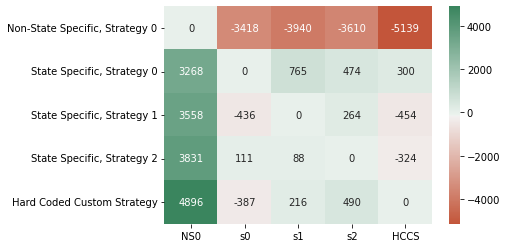

In [ ]:
win_array = []

x_axis_labels = [ "NS0", "s0", "s1", "s2", "HCCS"] # labels for x-axis
y_axis_labels = [ "Non-State Specific, Strategy 0", "State Specific, Strategy 0", "State Specific, Strategy 1", "State Specific, Strategy 2", "Hard Coded Custom Strategy"] # labels for x-axis


for i in range(5): 
    win_array.append([0] * len(possible_settings))

for r in range(5):
    for c in range(5):
        if (r,c) in pair_wins:
            pair_result = pair_wins[(r,c)]
            win_array[r][c] = pair_result[0] - pair_result[1]
#             print(pair_result[0] - pair_result[1], end="\t")
        else:
            win_array[r][c] = 0
#             print(0, end="\t")
#     print()

win_array = np.matrix(win_array)
win_array = win_array.astype(int)
ax = sns.heatmap(win_array, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap = sns.diverging_palette(20,145, as_cmap=True))



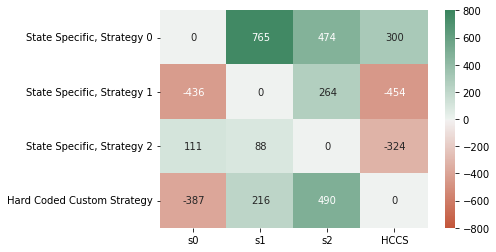

In [ ]:
win_array = []


x_axis_labels = [ "s0", "s1", "s2", "HCCS"] # labels for x-axis
y_axis_labels = [ "State Specific, Strategy 0", "State Specific, Strategy 1", "State Specific, Strategy 2", "Hard Coded Custom Strategy"] # labels for x-axis

for i in range(1,5): 
    win_array.append([0] * (len(possible_settings) - 1))

for r in range(1,5):
    for c in range(1,5):
        if (r,c) in pair_wins:
            pair_result = pair_wins[(r,c)]
            win_array[r-1][c-1] = pair_result[0] - pair_result[1]
#             print(pair_result[0] - pair_result[1], end="\t")
        else:
            win_array[r-1][c-1] = 0
#             print(0, end="\t")
#     print()

win_array = np.matrix(win_array)
win_array = win_array.astype(int)
ax = sns.heatmap(win_array, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap = sns.diverging_palette(20,145, as_cmap=True), vmin=-800, vmax=800)


## Play with the Bot(s)

In [11]:
dealer = True
human = True
num_decks = 1
num_players = 2

bot_state_specific = True
bot_strategy = 2

verbose = True
learn = False

filename = "bj_belief_" + str(bot_strategy) + ("s" * bot_state_specific) 

play_again = True

while play_again:
  tempfile = open(filename, 'rb')
  (generation, prior_belief) = pickle.load(tempfile)  
  # generation = how many rounds bot has been trained
  # prior_belief = trained beliefs for picking any given action
  tempfile.close()

  # at least 2 if dealer is not present, otherwise 1
  if (not dealer):
    num_players = max(num_players, 2)
  else:
    num_players = max(num_players, 1)

  human_turn = np.random.choice(num_players)
  names = ["Bot " + str(i) for i in range(num_players)]
  if human:
    names[human_turn] = "Human"
  if dealer:
    names.append("Dealer")

  if verbose : print("Players: " + str(names))

  # create and shuffle deck
  deck = []
  for nd in range(num_decks):
    for i in range(1,10):
      for suit in range(4):
        deck.append(i)
    for face in range(16):
      deck.append(10)
  np.random.shuffle(deck)

  # deal initial cards
  all_hands = []  # length = num_players (+1 if dealer exists)
  for p in range(num_players):
    all_hands.append([deck.pop(), deck.pop()])

  if(dealer):
    next_card = deck.pop()
    all_hands.append([next_card, ])

  if verbose : print("Starting Hands: " + str(all_hands))

  players = []

  for p in range(num_players):  # players go one at a time, COULD CHANGE THIS LATER?
    if verbose : print()
    curr_hand = tuple(all_hands[p])
    curr_opp_hands = []
    for p2 in range(len(all_hands)):
      if p2 != p:
        curr_opp_hands.append(tuple(all_hands[p2]))
    
    if human and (p == human_turn):
      curr_player = HumanPlayer(curr_hand,curr_opp_hands,num_decks=num_decks)
    else:
      curr_player = AutoPlayer(curr_hand,curr_opp_hands,num_decks=num_decks, state_specific=bot_state_specific, name=names[p], strategy=bot_strategy, iteration=generation, verbose=verbose, prior_belief=prior_belief)
    players.append(curr_player)

    while(curr_player.hit()):
      # deal player a card
      curr_card = deck.pop()
      all_hands[p].append(curr_card)
      curr_player.deal(curr_card)
      if bust(all_hands[p]):
        if verbose : print("[" + names[p] + "] Bust!")
        break

  # dealer's behavior, no variability
  if dealer:
    if verbose : print()
    while max(possible_values(all_hands[-1])) < 17:
      curr_card = deck.pop()
      all_hands[-1].append(curr_card)
      if verbose : print("[Dealer] Draws card: " + str(curr_card))
      if verbose : print("[Dealer] Hand: " + str(all_hands[-1]))

  if verbose : print()
  # decide who won
  winners = []
  max_score = -1
  for p in range(len(all_hands)):
    for valuation in possible_values(all_hands[p]):
      if valuation > 21:  # don't want to award win to a valuation that busts
        continue
      if valuation > max_score:
        max_score = valuation
        winners = [p,]
      elif valuation == max_score:
        winners.append(p)
  # print(winners)

  if(len(winners) > 0):
    reward = (len(all_hands) * 1.0/len(winners))-1
  else:
    reward = -1  # everyone busted

  if learn:
    final_belief = prior_belief 
    generation += 1

  # print("Before: " + str(final_belief))
  for p in range(num_players):
    if p in winners:
      players[p].win(reward)  # maybe reward inversely proportional to number of winners?
      # each player and dealer adds 1 unit to pool, which is split amongst winners
      # subtract one for initial investment
      curr_reward = reward
    else:
      players[p].lose(-1)
      curr_reward = -1
    if learn:
      if (not human) or (human and (p != human_turn)):
        change = players[p].change_belief(curr_reward)
        # print(change)
        if bot_state_specific:
          final_belief[change[0],change[1]] *= change[2]
        else:
          final_belief[change[1]]*=change[2]

  if learn:
    if bot_state_specific:
      final_belief /= np.sum(final_belief, axis=1)[:,None]
    else:
      final_belief /= np.sum(final_belief)

    # Sid's modification here. All I'm going to do is pickle load a matrix, append the current belief (final_belief), and then do nothing else
    # this should generate a matrix with the beliefs at each point
    # I might just do the probability of hitting (because p(standing) = 1 - p(hitting) )

    prior_beliefs.append(final_belief)

    tempfile = open(filename, 'wb')
    pickle.dump((generation,final_belief), tempfile)
    tempfile.close()

    tempfile = open(filenameCum, 'wb')
    pickle.dump(prior_beliefs, tempfile)
    tempfile.close()

  if(num_players in winners):
    if verbose : print("[Dealer] House wins " + str(reward) + " units.")
  elif dealer:  # dealer in the game but not in winners
    if verbose : print("[Dealer] House netted -1 unit.")

  play_again = (input('\nEnter \'y\' to play again: ') == 'y')

Players: ['Bot 0', 'Human', 'Dealer']
Starting Hands: [[5, 8], [1, 10], [10]]

[Bot 0] Starting hand: [5, 8]
[Bot 0] I choose to hit!
[Bot 0] Dealt card: 10
[Bot 0] Current hand: [5, 8, 10]
[Bot 0] Bust!

[Human] Your starting hand: [1, 10]
[Human] Type 'h' to hit, otherwise stand: s

[Dealer] Draws card: 10
[Dealer] Hand: [10, 10]

[Bot 0] Aw, I netted -1 units.
[Human] You won 2.0 units!
[Dealer] House netted -1 unit.

Enter 'y' to play again: n
